In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import json
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator import SimulatorMagnetic, SimulatorLennard
from simulator.models import Client, SimulationAlchemy as Simulation
from utils.utils import standartize

from tqdm.notebook import tqdm
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

In [2]:
items = client.get_simulation_groups(['Ensemble 4.1.lammps'])
[item.load_df() for item in tqdm(items)];

[item.load_history(keys=["rs","vs"]) for item in tqdm(items)];

100%|██████████| 40/40 [25:56<00:00, 38.91s/it]


In [3]:
item = items[0]
dt = item.record_interval
shift = 5000
potential_a = (1/item.a + 1/item.b)/2
eps = (1/item.b - 1/item.a)/2/potential_a

In [ ]:
item.df.index

Index([    0.0,     0.1,     0.2,     0.3,     0.4,     0.5,     0.6,     0.7,
           0.8,     0.9,
       ...
       14999.1, 14999.2, 14999.3, 14999.4, 14999.5, 14999.6, 14999.7, 14999.8,
       14999.9, 15000.0],
      dtype='float64', name='time', length=150001)

In [4]:
data = []
rs = []
vs = []
for item in tqdm(items):
    start = np.searchsorted(item.df.index, 10000)
    
    rs.append(item.history["rs"][start::10].transpose(0,2,1).reshape(-1,3))
    vs.append(item.history["vs"][start::10].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


In [5]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [6]:
omega_MLE, beta_MLE

(1.1665644785607512, 4.648424616878021)

In [7]:
rs.shape

(3, 104620920)

In [8]:
omega_MLE, beta_MLE

(1.1665644785607512, 4.648424616878021)

In [9]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=27.530589024174777, pvalue=1.0514982436981227e-06)

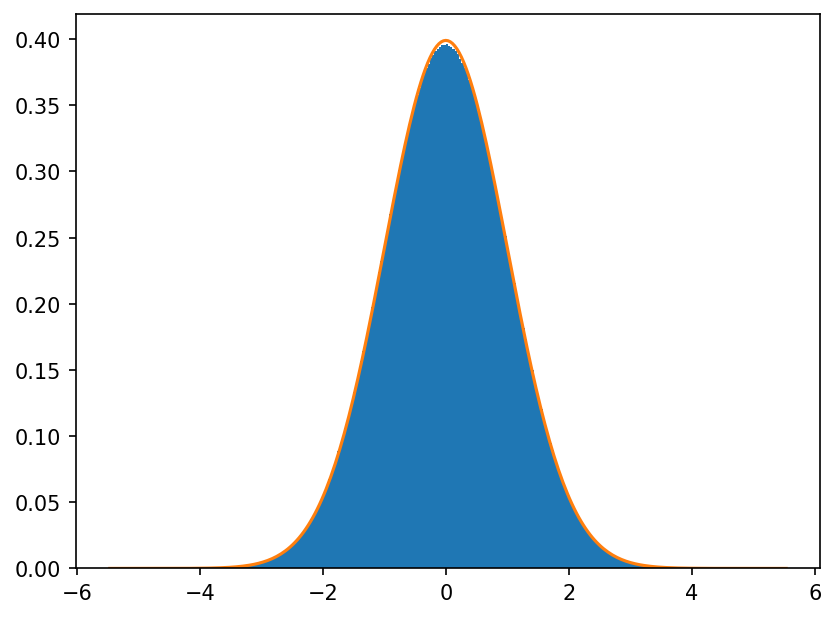

In [10]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

In [11]:
%%time
((osm, osr), (slope, intercept, _r)) = probplot(points[::100], dist="norm",)

CPU times: user 276 ms, sys: 52.3 ms, total: 328 ms
Wall time: 291 ms


In [13]:
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
#     ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
# )

N_ = 10**7

plot_data = (
    [np.random.choice(x, N_, replace=False) for x in 
     [standartize(vs[0]), standartize(rs[0]), residue[0], standartize(vs[2])]],
    ["$v_x$", "$r_x$","residue${}_x$", "$v_z$"]
)

In [14]:
import pickle
with open("QQ-data-4.1-(v2).pkl", "wb") as f:
    pickle.dump(plot_data, f)

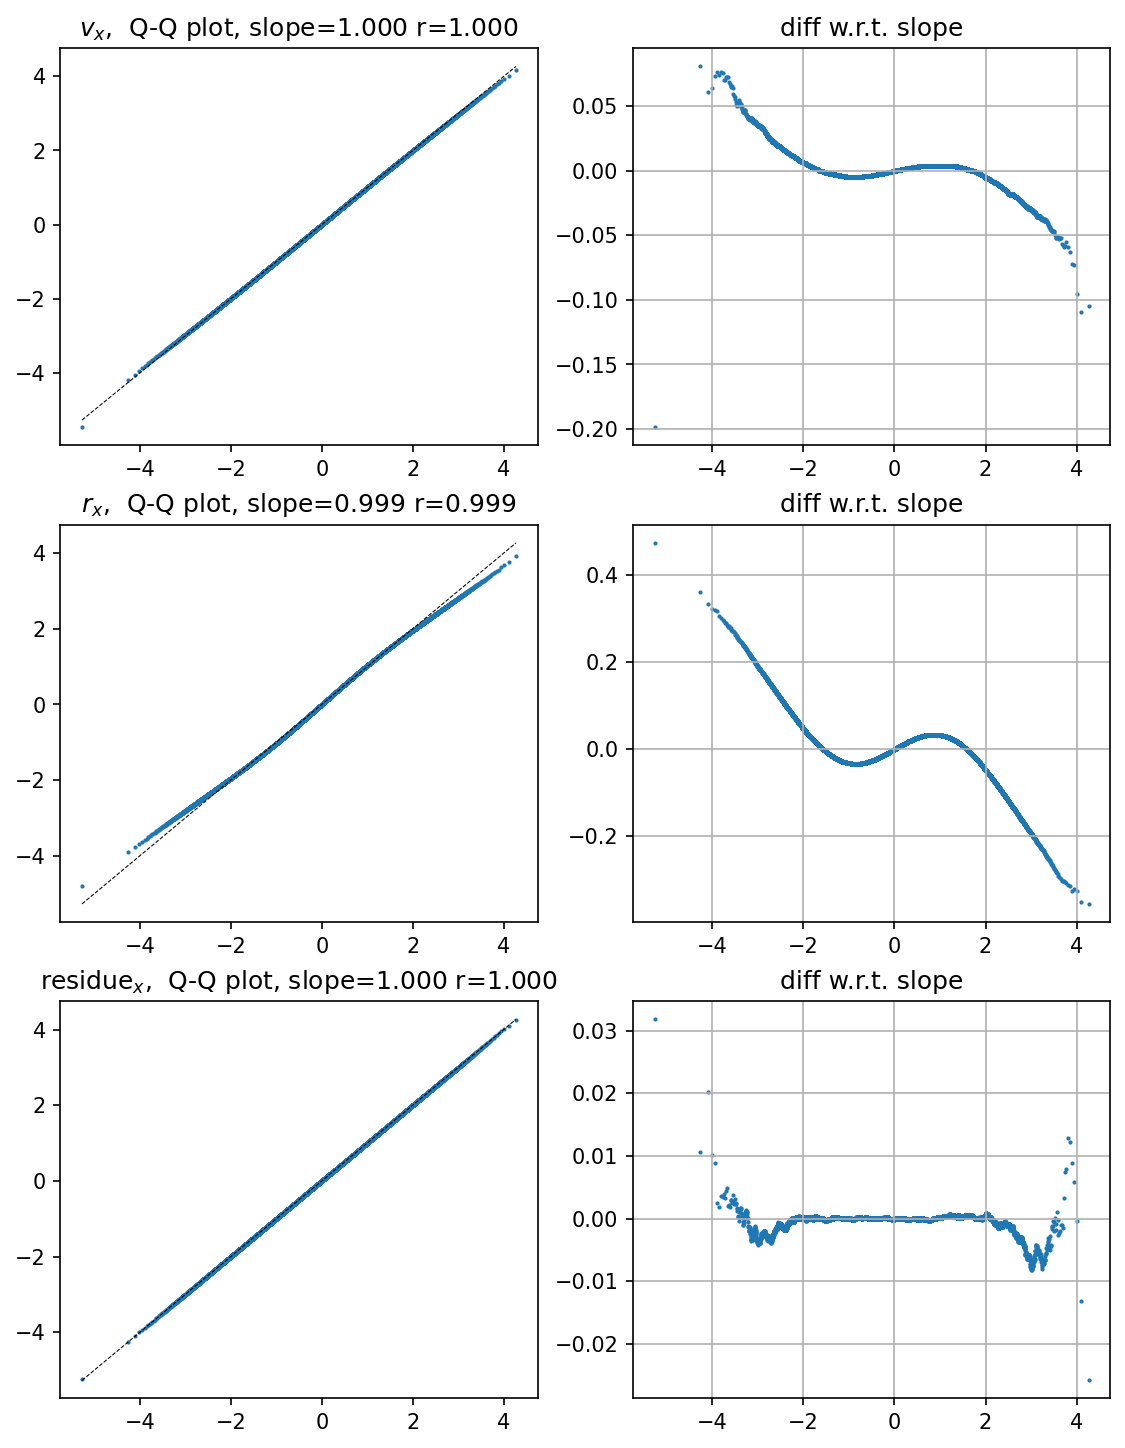

In [21]:
sp=100
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)